# Softmax com NLP

Para entendermos melhor como o softmax funciona, vamos desenvolver um modelo de classificação de emoções de NLP multiclasse com base em um dataset do Kaggle e análise de gráficos usando a biblioteca do Bokeh :)

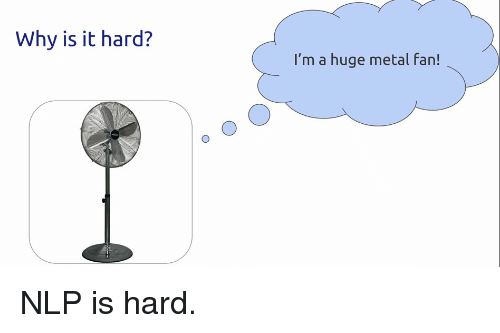


#Perguntas!

Aqui vou anotar cada "método" que irei usar para fazer esse código :)

##Classification problem:
Nosso problema será de classificação multiclasse, ou seja, de um determinado texto, quais serão as emoções. No nosso dataset temos as seguintes emoções:
  * Fear
  * Anger
  * Sadness
  * Love
  * Joy
  * Suprise

##Loss function:
Normalmente, em problemas envolvendo softmax, Cross Entropy Loss tende a ser a função de perda.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Análise de Sentimentos/Tarefas/Food Review Project')

In [ ]:
#Importando minha biblioteca com as funções que fiz :)
import utils
from utils import *

In [ ]:
#Importes
import pandas as pd
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

#Baixar o dataset
Link do dataset: https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp?select=train.txt

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Análise de Sentimentos/Tarefas/Softmax/train.txt", sep=';', names=['text','emotion'])
# df = df.sample(1000)  #Comente essa linha se quiser usar o dataset todo :)
df

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


# Convertendo categorias em números

Se quisermos que nosso modelo compreenda as categoras, devemos transformá-as em números, para ser mais simples, usarei uma função do Pandas :)

In [ ]:
df['emotion'] = pd.Categorical(df['emotion'])

In [ ]:
df.dtypes

text         object
emotion    category
dtype: object

In [ ]:
df['emotion_code'] = df['emotion'].cat.codes
df

,text,emotion,emotion_code
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,4
15996,i am now turning and i feel pathetic that i am...,sadness,4
15997,i feel strong and good overall,joy,2
15998,i feel like this was such a rude comment and i...,anger,0


# Convertendo texto em números :)

Para isso vamos tentar usar o famoso, embebedar (embedding)

In [ ]:
#Primeiro a limpazem com as minhas funções que não canso de usar :)
df['text_code'] = df['text'].apply(lambda x: clean_text(x))
df

,text,emotion,emotion_code,text_code
0,i didnt feel humiliated,sadness,4,"[didnt, feel, humili]"
1,i can go from feeling so hopeless to so damned...,sadness,4,"[go, feel, hopeless, damn, hope, around, someo..."
2,im grabbing a minute to post i feel greedy wrong,anger,0,"[im, grab, minut, post, feel, greedi, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,3,"[ever, feel, nostalg, fireplac, know, still, p..."
4,i am feeling grouchy,anger,0,"[feel, grouchi]"
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,4,"[brief, time, beanbag, said, anna, feel, like,..."
15996,i am now turning and i feel pathetic that i am...,sadness,4,"[turn, feel, pathet, still, wait, tabl, sub, t..."
15997,i feel strong and good overall,joy,2,"[feel, strong, good, overal]"
15998,i feel like this was such a rude comment and i...,anger,0,"[feel, like, rude, comment, im, glad]"


In [ ]:
#Criando EL VOCABULÁRIO (Com ajuda do código do sor em: Introdução ao PyTorch: da Regressão Linear à NLP com word-embeddings)
vocab_set = set() # será usado para gerar o vocabulário principal
max_len_doc = 0   # vamos medir o maior comprimento das mensagens envidas, em número de tokens
sum_len_doc = 0   # vamos medir o valor médio de palavras (tokens) por mensagem
min_word_len = 3  # comprimento mínimo de um token (em número de caracteres) para entrar no vocabulário 
tokens_list = []  # salvar a lista de tokens

for doc in df['text_code']: # para cada documento do dataset
  #Pegando a palavra apenas se ela é maior que o comprimento mínimo
  for word in doc: 
    if len(word)>=min_word_len:
      tokens_list.append(word)

  # uso da função set: cria um conjunto dos elementos únicos da lista
  tokens_set = set(tokens_list)
  vocab_set = set.union(vocab_set, tokens_set) # adiciona elementos únicos que ainda não pertencem ao conjunto do vocabulário

  sum_len_doc += len(word)
  if len(word) > max_len_doc:
    max_len_doc=len(word)

print(f'Tamanho total do vocabulário: V={len(vocab_set)}')
print(f'Número de palavras do texto mais longo: {max_len_doc}')
print(f'Média de palavras por texto: {sum_len_doc/len(df):3.4f}')

Tamanho total do vocabulário: V=10152
Número de palavras do texto mais longo: 31
Média de palavras por texto: 5.2553


In [ ]:
word2idx = dict({})        # inicializa o dicionário
word2idx['<OOV>'] = 0      # índice da tag "out of vocabulary" é 0
word2idx['<PAD>'] = 1      # índice da tag "padding token" é 1

for i, v in enumerate(sorted(vocab_set),start=2): # enumera o vocabulário em ordem alfabética, a partir do índice 2
  word2idx[v] = i

# testando a conversão "word to index" com o dicionário:
print(f'index for "<PAD>": {word2idx["<PAD>"]}')
print(f'index for "feel": {word2idx["feel"]}')

index for "<PAD>": 1
index for "feel": 3182


In [ ]:
idx2word = list(word2idx.keys()) # apenas transforma as chaves (palavras ordenadas) do dicionário word2idx em uma lista

# testando a conversão "index to word":
print(f'word for index 0:    {idx2word[0]}')
print(f'word for index 100": {idx2word[100]}')

word for index 0:    <OOV>
word for index 100": addl


Agora sim, vamos codificar os textos :)

In [ ]:
max_len = 50         # comprimento máximo da mensagem (em número de palavras)
encoded_docs = []    # inicializa a lista de documentos codificados

for doc in df['text_code']: # para cada texto
  encoded_d = [word2idx.get(t,word2idx['<OOV>']) for t in doc]    # codifica o documento usando o dicionário word2idx
  encoded_d += [word2idx['<PAD>']]*max(0, max_len-len(encoded_d))    # adiciona o padding, se necessário
  
  encoded_docs.append(encoded_d[:max_len])                           # trunca o documento e salva na lista de documentos codificados

len(encoded_docs)  

16000

In [ ]:
# import json

# with open('/content/drive/My Drive/Análise de Sentimentos/Projeto para 08-09/vocab.json', 'w') as fp:
#     json.dump(word2idx, fp)

In [ ]:
df['text_code'] = encoded_docs
df

,text,emotion,emotion_code,text_code
0,i didnt feel humiliated,sadness,4,"[2354, 3182, 4241, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,i can go from feeling so hopeless to so damned...,sadness,4,"[0, 3182, 4186, 2096, 4185, 458, 8220, 1294, 5..."
2,im grabbing a minute to post i feel greedy wrong,anger,0,"[0, 3748, 5647, 6792, 3182, 3793, 10044, 1, 1,..."
3,i am ever feeling nostalgic about the fireplac...,love,3,"[2979, 3182, 6087, 3265, 4922, 8467, 6950, 1, ..."
4,i am feeling grouchy,anger,0,"[3182, 3821, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,4,"[1088, 9015, 735, 7588, 343, 3182, 5144, 740, ..."
15996,i am now turning and i feel pathetic that i am...,sadness,4,"[9264, 3182, 6468, 8467, 9735, 8751, 8568, 881..."
15997,i feel strong and good overall,joy,2,"[3182, 8531, 3724, 6310, 1, 1, 1, 1, 1, 1, 1, ..."
15998,i feel like this was such a rude comment and i...,anger,0,"[3182, 5144, 7526, 1696, 0, 3667, 1, 1, 1, 1, ..."


#Train Teste Split com Stratify

In [ ]:
df['emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

In [ ]:
#Get data
X = df['text_code']
y = df['emotion_code']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [ ]:
y_train.value_counts()

2    4021
4    3500
0    1619
1    1453
3     978
5     429
Name: emotion_code, dtype: int64

In [ ]:
moods = {"Anger": 0, "Fear" : 1, "Joy" : 2, "Love" : 3, "Sadness" : 4, "Suprise" : 5}

#Criação do Modelo :)
Socorro

In [ ]:
class Torch_Mean_Layer(nn.Module):
  '''Camada personalizada: calcula a média do tensor dentrada sobre a dimensão 1 (colunas).
     Retorna um vetor linha, onde cada elemento é a média dos elementos da coluna correspondente do tensor de entrada.
  '''
  def forward(self, x, dim=1):
    x = torch.sum(x, dim=dim, keepdims=True)/x.shape[1]
    return x


class mood_classifier(nn.Module):
  '''Modelo classificador de emoções
  '''

  # ----------------------------------------------#
  # Método construtor
  def __init__(self, vocab_size, dim_embed, n_units): 
    super().__init__()  

    embedding_seq = [] # 
    ann_seq       = [] # 
    soft_seq      = []

    #---------------------------------------------------------------#
    # Embedding step: sequência de operações para converter X --> h
    #Matriz de 1s
    
    embedding_seq.append(
        nn.Embedding(num_embeddings=vocab_size, embedding_dim=dim_embed) # camada "embedding": categórico (tamanho V) para R^d
    )
    embedding_seq.append(Torch_Mean_Layer()) 
    #---------------------------------------------------------------#

    #--------------------------------------------------------------------------#
    # ANN: Rede Neural Artifical Tradicional, com regressão logística na saída
    ann_seq.append(nn.Linear(dim_embed, n_units))
    ann_seq.append(nn.ReLU(inplace=True))
    ann_seq.append(nn.Linear(n_units, 6))
    
    #--------------------------------------------------------------------------#
    # Softmax :)
    soft_seq.append(nn.LogSoftmax(dim=1))

    #--------------------------------------------------------------------------#

    #--------------------------------------------------------------------------#
    # "merge" de todas as camamadas em uma layer sequencial 
    # (uma sequência para cada etapa)
    self.embedding = nn.Sequential(*embedding_seq)     # etapa de embedding 
    self.ann       = nn.Sequential(*ann_seq)           # etapa ANN
    self.soft      = nn.Sequential(*soft_seq)
    #--------------------------------------------------------------------------#


  def forward(self, x): 
    '''Processamento realizado ao chamar y=modelo(x)
    '''
    x = self.embedding(x)  # aplica a etapa de embedding
    x = self.ann(x)        # passa o embedding médio pelas camadas da ANN
    x = x.view(-1,6)
    x = self.soft(x)
    return x  #Adcionar o softmax

#Treinamento?
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [ ]:
def train_loop(model, data, max_epochs = 1000, print_iters = 5):
  X_train, Y_train = data
  losses = []
  accs = []
  for i in range(max_epochs): # para cada época

      #-----------------------------------#
      # INÍCIO DO WORKFLOW DO TREINAMENTO #
      # 
      # Add mistura
      Y_pred = model.forward(X_train)         # apresente os dados de entrada para o modelo, e obtenha a previsão    
      loss = criterion(Y_pred.view(-1, 6), Y_train.view(-1))       # calcule a perda (o custo, o erro)
      optimizer.zero_grad()                   # inicialize os gradientes
      loss.backward()                         # backpropagation sobre a perda atual (cálculo dos novos gradientes) 
      optimizer.step()                        # atualização dos parâmetros da rede utilizando a regra do otimizador escolhido

      # mascarando PAD e OOV no gradiente e nos pesos, respectivamente
      model.embedding[0].weight.grad[[0,1],:] = torch.zeros_like(model.embedding[0].weight.grad[[0,1],:])
      model.embedding[0].weight.data[[0,1],:] = torch.zeros_like(model.embedding[0].weight.data[[0,1],:])
      
      # FIM DO WORKFLOW DO TREINAMENTO    #
      #-----------------------------------#

      # ------ Bloco Opcional ------ #
      # Salvando métricas
      losses.append(loss)                     # salvando a perda atual
      acc = calc_accuracy(Y_pred, Y_train)     # calcula a taxa de acerto atual
      accs.append(acc)
      
      # Imprimindo resultados parciais
      if i % print_iters ==0: # a cada 10 iterações
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}') 
      #-----------------------------------#

  #----------------------------------------------------------------------------# 
  print('\n# Finished training!')
  print(f'# --> epoch: {i}  \n# --> initial loss: {losses[0]:10.8f} ,  \n# --> accuracy: {acc:2.8f} , \n# --> final loss: {losses[-1]:10.8f}')
  
  # retornando resultados
  return model, losses, accs

# Redefinindo cálculo da taxa de acerto 
def calc_accuracy(y_pred, y_true):
  ''' Helper function para calcular a taxa de acerto deste exemplo.
  '''
  y_pred = torch.argmax(y_pred, dim=1)
  y_pred = y_pred.float()
  y_true = torch.squeeze(y_true)
  y_pred = torch.squeeze(y_pred)
  num_hits  = torch.sum(y_pred==y_true).numpy()
  num_total =  float(y_true.numel())
  acc=  num_hits/num_total
  return acc

In [ ]:
X_train = np.vstack(X_train)
Y_train = np.array(y_train).reshape(-1,1)
X_train.shape, X_train[0].shape, Y_train.shape, Y_train[0].shape

((12000, 50), (50,), (12000, 1), (1,))

In [ ]:
data_train = (torch.LongTensor(X_train), torch.LongTensor(Y_train))

Model = mood_classifier(vocab_size=len(word2idx), dim_embed=50, n_units=100)
print(Model)

criterion = nn.NLLLoss() # cross entropy loss
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.01) 

Model, losses, accs = train_loop(Model, data_train, max_epochs=300, print_iters=1) # note que o modelo é sobrescrito pela saída treinada

mood_classifier(
  (embedding): Sequential(
    (0): Embedding(10154, 50)
    (1): Torch_Mean_Layer()
  )
  (ann): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=6, bias=True)
  )
  (soft): Sequential(
    (0): LogSoftmax(dim=1)
  )
)
epoch:  0  loss: 1.70705366
epoch:  1  loss: 1.77194250
epoch:  2  loss: 1.74412727
epoch:  3  loss: 1.71639001
epoch:  4  loss: 1.68856287
epoch:  5  loss: 1.66073465
epoch:  6  loss: 1.63389289
epoch:  7  loss: 1.60996985
epoch:  8  loss: 1.59157443
epoch:  9  loss: 1.58090675
epoch: 10  loss: 1.57759881
epoch: 11  loss: 1.57738459
epoch: 12  loss: 1.57485819
epoch: 13  loss: 1.56771576
epoch: 14  loss: 1.55676663
epoch: 15  loss: 1.54400194
epoch: 16  loss: 1.53119934
epoch: 17  loss: 1.51923192
epoch: 18  loss: 1.50802088
epoch: 19  loss: 1.49665785
epoch: 20  loss: 1.48388410
epoch: 21  loss: 1.46851754
epoch: 22  loss: 1.44982696
epoch: 23  loss: 1.42

In [ ]:
# torch.save(Model, "/content/drive/My Drive/Análise de Sentimentos/Projeto para 08-09/Models/newmodel.pth")

In [ ]:
# print("Model's state_dict:")
# for param_tensor in Model.state_dict():
#     print(param_tensor, "\t", Model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
# torch.save(Model.state_dict(), '/content/drive/My Drive/Análise de Sentimentos/Projeto para 08-09/Models/newmodel_dict')

In [ ]:
# e = next(Model.embedding[0].parameters())
# e.data

#EL confusione Matrix

In [ ]:
X_train = torch.LongTensor(X_train)
Y_train = torch.LongTensor(Y_train)
X_test = np.vstack(X_test)
X_test = torch.LongTensor(X_test)
Y_test = np.array(y_test).reshape(-1,1)

In [ ]:
Y_pred = Model.forward(X_test)         

In [ ]:
Y_pred = torch.argmax(Y_pred, dim=1)

In [ ]:
Y_pred = Y_pred.view(-1)
Y_pred.shape

torch.Size([4000])

In [ ]:
moods

{'Anger': 0, 'Fear': 1, 'Joy': 2, 'Love': 3, 'Sadness': 4, 'Suprise': 5}

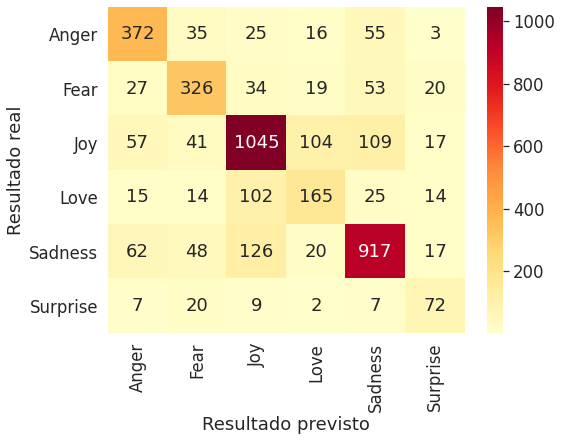

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1.5)

matriz_de_confusao = confusion_matrix(Y_pred, y_test)

#criando list com as emoções
emotion_class = ['Anger','Fear','Joy','Love','Sadness','Surprise']

df_matriz_de_confusao = pd.DataFrame(matriz_de_confusao, emotion_class, emotion_class)

# confusion matrix daora TEM Q MELHORAR
def plot_conf_mat(y_test, y_preds, norm='true'):
   fig, ax = plt.subplots(figsize=(8, 6))
   ax = sns.heatmap(df_matriz_de_confusao,
                   annot=True,
                    fmt="d",
                    cmap="YlOrRd")
   plt.xlabel("Resultado previsto")
   plt.ylabel("Resultado real")


plot_conf_mat(Y_test, Y_pred)

In [ ]:
moods

{'Anger': 0, 'Fear': 1, 'Joy': 2, 'Love': 3, 'Sadness': 4, 'Suprise': 5}

#Tentando plotar  "loss x epochs" e "acc x epochs"

In [ ]:
def plot_loss_and_accuracy(losses, accs):

  fig, ax_tuple = plt.subplots(1, 2, figsize=(16,6))
  fig.suptitle('Loss and accuracy')

  for i, (y_label, y_values) in enumerate(zip(['CE loss','Accuracy'],[losses, accs])):
    ax_tuple[i].plot(range(len(y_values)),  y_values, label='train')
    ax_tuple[i].set_xlabel('epochs')
    ax_tuple[i].set_ylabel(y_label)
    ax_tuple[i].legend()

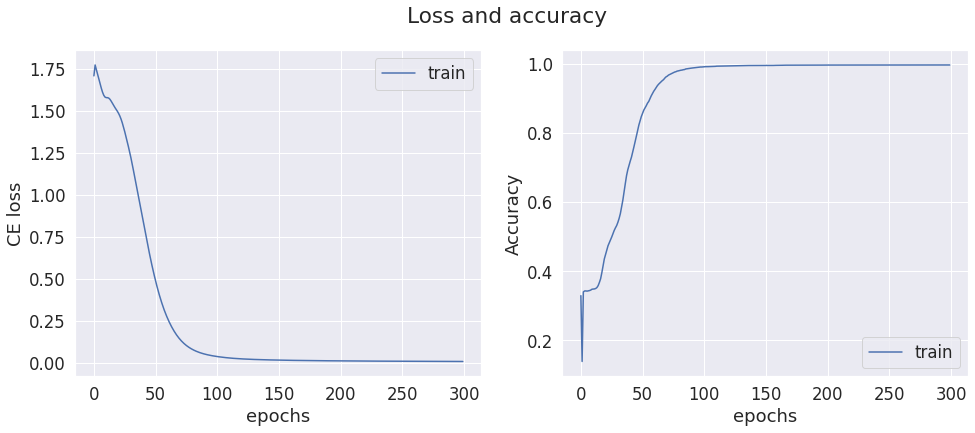

In [ ]:
plot_loss_and_accuracy(losses, accs)

In [ ]:
# data_train = (torch.LongTensor(X_train), torch.LongTensor(Y_train))

# model = torch.load("/content/drive/My Drive/Análise de Sentimentos/Projeto para 08-09/Models/model.pth")
# model.eval()

# criterion = nn.NLLLoss() # cross entropy loss
# optimizer = torch.optim.Adam(Model.parameters(), lr = 0.01) 

# model, losses, accs = train_loop(model, data_train, max_epochs=200, print_iters=5) # note que o modelo é sobrescrito pela saída treinada

https://gluon-nlp.mxnet.io/examples/word_embedding/word_embedding.html